# Running variational quantum algorithms with Amazon Braket Hybrid Jobs

Amazon Braket Hybrid Jobs offers a way for you to run hybrid quantum-classical algorithms that require both classical resources and quantum processing units (QPUs). Hybrid Jobs is designed to spin up the requested classical compute, run your algorithm, and release the instances after completion so you only pay for what you use. This workflow is ideal for long-running iterative algorithms involving both classical and quantum resources. In this notebook we show you how to run such a job via the qiskit-braket provider.

Read more at https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html

## Prepare Hybrid Job script

The job script defines the specific quantum logic to be executed on the quantum processor and the classical processing that the output is saved to, in this case, setting up the device backend and saving the job results. To learn more about what the VQE is, see this example: https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/hybrid_[…]lgorithms/VQE_Transverse_Ising/VQE_Transverse_Ising_Model.ipynb


In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import BackendEstimatorV2
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import SLSQP

from braket.aws import AwsDevice
from braket.devices import Devices
from braket.jobs import hybrid_job, save_job_result
from qiskit_braket_provider import BraketProvider

sv1 = AwsDevice(Devices.Amazon.SV1)

In [11]:
@hybrid_job(device=sv1.arn, include_modules="qiskit_algorithms")
def main():
    """Decorated function that will be run in the docker container."""
    backend = BraketProvider().get_backend("SV1")

    h2_op = SparsePauliOp(
        ["II", "IZ", "ZI", "ZZ", "XX"],
        coeffs=[
            -1.052373245772859,
            0.39793742484318045,
            -0.39793742484318045,
            -0.01128010425623538,
            0.18093119978423156,
        ],
    )

    estimator = BackendEstimatorV2(backend=backend, options={"default_precision": 0.1})
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    slsqp = SLSQP(maxiter=1)

    vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=slsqp)

    vqe_result = vqe.compute_minimum_eigenvalue(h2_op)

    # Save the results of the VQE computation.
    save_job_result(
        {
            "VQE": {
                "eigenvalue": vqe_result.eigenvalue.real,
                "optimal_parameters": list(vqe_result.optimal_parameters.values()),
                "optimal_point": vqe_result.optimal_point.tolist(),
                "optimal_value": vqe_result.optimal_value.real,
            }
        }
    )

## Running your job
Amazon Braket provides a container for Hybrid Jobs with the Qiskit-Braket provider preinstalled. We can start your hybrid job by executing the decorated function `main`.

In [12]:
job = main()

In [13]:
result = job.result()
pprint(result)

{'VQE': {'eigenvalue': -0.8313108616052497,
         'optimal_parameters': [2.9023333807957403,
                                -2.3382025632041454,
                                -2.8582366784216995,
                                1.6415290038248314,
                                0.15719218864851658,
                                -2.8968111266519774,
                                -5.273734801107682,
                                -6.143328105810579],
         'optimal_point': [2.9023333807957403,
                           -2.3382025632041454,
                           -2.8582366784216995,
                           1.6415290038248314,
                           0.15719218864851658,
                           -2.8968111266519774,
                           -5.273734801107682,
                           -6.143328105810579],
         'optimal_value': -0.8313108616052497}}


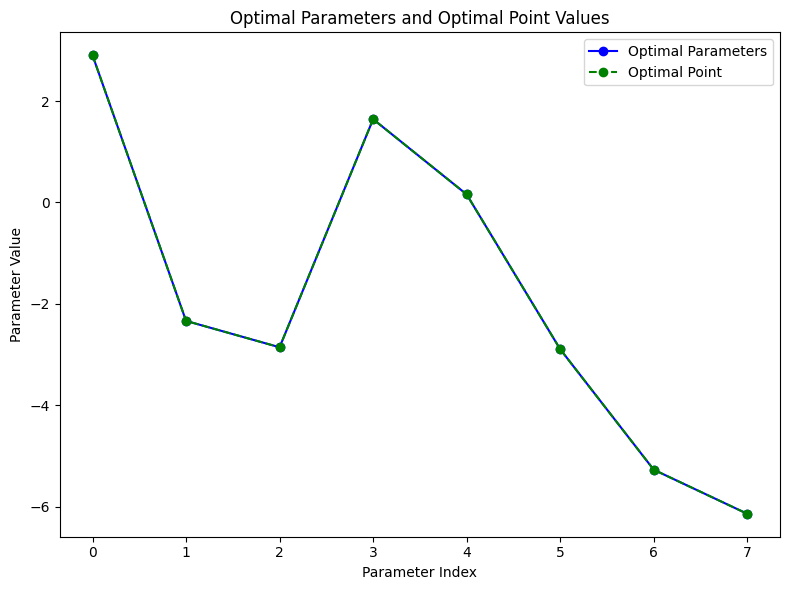

In [14]:
# Extract data for visualization
optimal_parameters = result["VQE"]["optimal_parameters"]
optimal_point = result["VQE"]["optimal_point"]

# Create a single plot for both sets of data
plt.figure(figsize=(8, 6))

# Plot Optimal Parameters
plt.plot(optimal_parameters, marker="o", linestyle="-", color="b", label="Optimal Parameters")

# Plot Optimal Point Values
plt.plot(optimal_point, marker="o", linestyle="--", color="g", label="Optimal Point")

# Set labels and title
plt.xlabel("Parameter Index")
plt.ylabel("Parameter Value")
plt.title("Optimal Parameters and Optimal Point Values")

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()